# Indiana Pines

1. Import dependencies

In [ ]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from sklearn.model_selection import train_test_split

from lightning import Trainer

from src.util.torch_device import resolve_torch_device
from src.util.patches import extract_patches, scale_patched
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.visualization.plot import plot_segmentation_comparison
from src.model.hsi_vit import HsiVisualTransformer
from src.data.dataset_decorator import UnlabeledDatasetDecorator

2. Prepare env

In [ ]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 32
patch_size = 9
num_epochs = 12
learning_rate = 1e-3

device = resolve_torch_device()

In [ ]:
torch.set_float32_matmul_precision("medium")

In [ ]:
f"Device is {device}"

3. Load dataset

In [ ]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [ ]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [ ]:
scale, x = scale_patched(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=random_seed, stratify=y
)

In [ ]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(x, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

In [ ]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [ ]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

In [ ]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

# CNN

1. Train model

In [ ]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(image_c, num_classes), num_classes, lr=learning_rate
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

In [ ]:
trainer.fit(model, train_loader, test_loader)

2. Display prediction

In [ ]:
y_pred = model(x_tensor)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)

# ViT

1. Train model

In [ ]:
n_splits = 20
n_blocks = 12
hidden_d = 384
n_heads = 12
patch_size = 9
num_epochs = 6
learning_rate = 1e-3

In [ ]:
model = HyperSpectralImageClassifier(
    HsiVisualTransformer(
        patch_shape=x_train_tensor.shape[1:],
        n_splits=n_splits,
        n_blocks=n_blocks,
        hidden_d=hidden_d,
        n_heads=n_heads,
        out_d=num_classes,
    ),
    num_classes,
    lr=learning_rate,
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

In [ ]:
trainer.fit(model, train_loader, test_loader)

2. Display prediction

In [ ]:
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)

y_pred = trainer.predict(model, predict_loader)

In [ ]:
y_pred = torch.cat(y_pred, dim=0)

In [ ]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

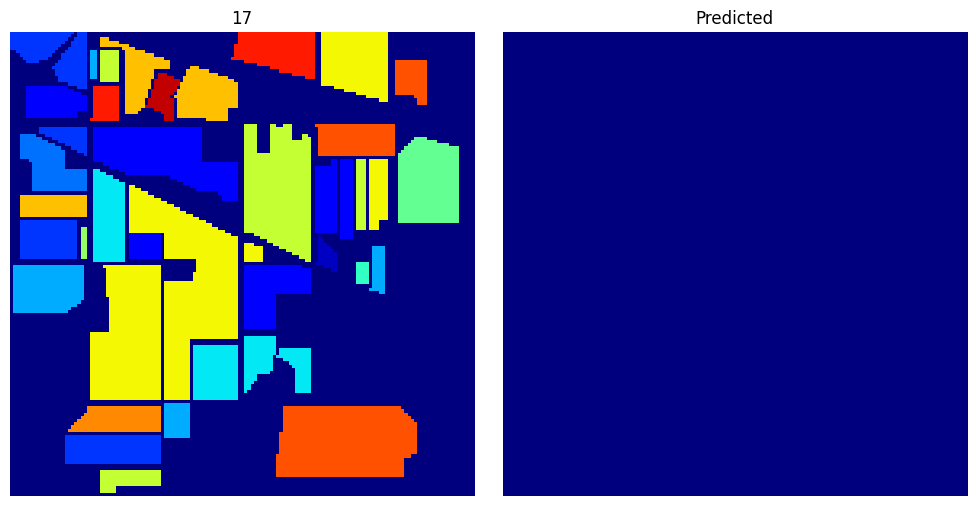

In [36]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)